## VK Visual Insights

### Описание проекта

В эпоху цифровизации традиционные методы изучения аудитории оффлайн мероприятий — онлайн-регистрация, подписки, анкетирование — всё чаще **дают искажённую картину**:

* Люди подписаны на группу, но давно отключили уведомления и не участвуют в жизни сообщества.
* В интернете много "мусора" - **ботов**, фейковых или неактивных аккаунтов.
* Многие участники мероприятий **не зарегистрированы в соцсети**, но активно участвуют оффлайн.
* При разовых мероприятиях — пользователь может появиться на один день и **не оставить цифрового следа**.

Таким образом, **реальная аудитория** мероприятия остаётся вне поля зрения.

---

**Почему именно фото + цифровой след?**

Мы предлагаем альтернативный способ получить **актуальную информацию** о посетителях мероприятия — это **анализ фотографий** с помощью нейросетей и сопоставление их с **цифровым следом** в соцсетях.

* Фото с мероприятий фиксируют **факт реального присутствия** — в отличие от регистрации или лайка.
* Компьютерное зрение позволяет **распознать пол, возраст, эмоции** — давая представление о настоящей, а не номинальной аудитории.
* Цифровой след (посты, комментарии, сторис) отражает **эмоциональную реакцию, интересы и вовлечённость**.

---

**Почему важно анализировать в динамике?**

Если мероприятие проводится ежегодно, можно изучить:

* Как **меняется состав аудитории** (молодеет/стареет, становится более мужским/женским).
* Как меняется **вовлечённость в постах и репостах**.
* Какие **темы и эмоции** преобладают в разное время.
* И главное — как это соотносится с реальными людьми, попавшими на фото.

---

**Что делает VK Visual Insights?**

**VK Visual Insights** — это аналитическое приложение, способное обрабатывать сотни и тысячи фотографий с мероприятий, объединяя:

*  Компьютерное зрение (распознавание лиц, пола, возраста, эмоций)
*  Анализ цифрового следа (VK API, посты, теги, комментарии)
*  Сравнение по годам, построение трендов и рекомендаций

---

**Что в итоге?**

* **Реальная демография** участников
* **Понимание интересов** сообщества
* **Рекомендации по продуктам, рекламе и партнёрам**
* **Оценка изменений** в аудитории мероприятия по годам


### Библиотеки

In [1]:
#Импортируем необходимые базовые библиотеки
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Анализ постов  VK
import vk_api
import time
import datetime as dt
from vk_api.exceptions import ApiError

# Анализ тематики постов VK
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import corpora

import warnings
warnings.filterwarnings("ignore")

#Общие настройки вида таблиц
# Форматирование таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.width', 500)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("darkgrid")

# создание константы RANDOM_STATE, TEST_SIZE
RANDOM_STATE = 210425
TEST_SIZE = 0.25

### Константы

In [2]:
# Настройки доступа в VK (токен для контакта у которого есть права на группу)
# Инструкция: https://dev.vk.com/api/access-token/getting-started
TOKEN = '618a8c5d618a8c5d618a8c5dc662baa2736618a618a8c5d0981bb4c8635c90c0f8a5ebd'

# Идентификатор группы VK
GROUPS = {
    "westra_tk": -403500  # Туристический клуб Вестра
}

# Идентификаторы альбомов по годам
ALBUM_IDS = {
    "westra_tk": [
        306954587,
        302408908,
        292582934,
        283784929
    ]
}
#======================================================================================================================
# Обработка картинок
RESIZE_DIM = (1280, 1280)

MAX_PHOTOS = 1300  # Лимит фотографий на сообщество
PREF_SIZES = [ "z", "y", "x", "m", "s"] #размеры фотографий, выбирается бОльшее из найденных 
FACE_SIZE = 50 #Минимально возможный размер куска фотографии с лицом, отфильтровать "мусор"
THRESHOLD = 0.50  # Порог схожести (чем меньше, тем строже)

PHOTO_PATH = 'data/raw/'
FACE_PATH =  "data/faces_raw"
UNIQUE_PATH = 'data/faces_unique'
EMBED_PATH = "data/face_embeddings.npy"
OUTPUT_CSV = "dataset/analysis_photo.csv"  # Файл для сохранения результатов
#======================================================================================================================
# Поиск цифрового следа
SEARCH_TEXT = "тгт"
START_TIME = int(dt.datetime(2022, 1, 1).timestamp())
END_TIME   = int(dt.datetime(2025, 10, 1).timestamp())
POSTS_LIMIT = 1000
SUB_QUERY = ['соревнования', 'вестра', 'занял', 'место', 'Полушкино', 'Тучково']

OUTPUT_CSV_POST = "dataset/analysis_post.csv"  # Файл для сохранения результатов постов

#======================================================================================================================
# Анализ эмоционального фона и продуктовых тематик
OUTPUT_LDA_TOPICS = 'dataset/lda_topics.txt'
OUTPUT_CSV_REC = 'dataset/recommendations.csv'

# ─── Готовых маркетинговых словарей на русском языке, на данный момент нет, но словарь под ─────
# ─── любую тематику можно с помощью ChatGPT или YandexGPT ──────────────────────────────────────
theme_to_category = {
    'cоревнования': 'Спортивная одежда, спортивные товары',
    'спорт': 'Спортивная одежда, спортивные товары',
    'путешествия': 'Туристическое снаряжение, одежда для туризма',
    'туризм': 'Туристическое снаряжение, туристические услуги',
    'электроника': 'Гаджеты, умные часы, наушники',
    'фитнес': 'Фитнес-клубы, спортивное питание',
    'мотоциклы': 'Экипировка для мотоциклистов, мотоаксессуары',
    'авто': 'Автоаксессуары, шины, масла',
    'еда': 'Продукты, доставка еды',
    'здоровье': 'Витамины, аптечные товары',
    'развлечения': 'Билеты на концерты, мероприятия',
    'отдых': 'Путёвки, отдых на природе'
}


### Функции для групповых графиков

In [3]:
from group_graph import hist_graph, bar_graph, kde_graph_count, kde_graph

## Анализ фотографий

### Парсинг фотографий из VK

In [5]:
from photo_utils import  download_photos, detect_and_save_faces

# Скачиваем фотографии из открытых альбомов в социальной сети VK
#download_photos(TOKEN, GROUPS, ALBUM_IDS, PHOTO_PATH, MAX_PHOTOS , PREF_SIZES)

detect_and_save_faces(PHOTO_PATH, FACE_PATH, FACE_SIZE)


=== Обработка лиц: 2022 ===
Найдено 16 изображений...


Лица 2022: 100%|███████████████████████████████████████████████████████████████████████| 16/16 [03:13<00:00, 12.11s/it]


Сохранено 1 лиц в data/faces_raw\2022
Эмбеддинги в data/faces_raw\2022_embeddings.pkl

=== Обработка лиц: 2023 ===
Найдено 8 изображений...


Лица 2023: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [01:15<00:00,  9.40s/it]


Сохранено 3 лиц в data/faces_raw\2023
Эмбеддинги в data/faces_raw\2023_embeddings.pkl

=== Обработка лиц: 2024 ===
Найдено 12 изображений...


Лица 2024: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [02:08<00:00, 10.72s/it]


Сохранено 2 лиц в data/faces_raw\2024
Эмбеддинги в data/faces_raw\2024_embeddings.pkl

=== Обработка лиц: 2025 ===
Найдено 20 изображений...


Лица 2025: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.85s/it]

Сохранено 8 лиц в data/faces_raw\2025
Эмбеддинги в data/faces_raw\2025_embeddings.pkl


### Поиск лиц

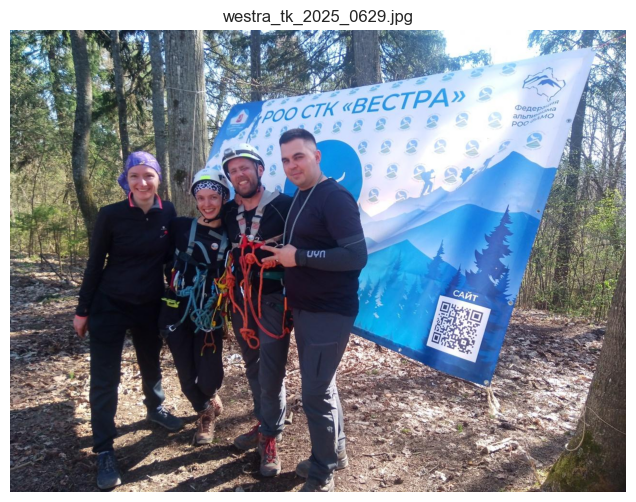

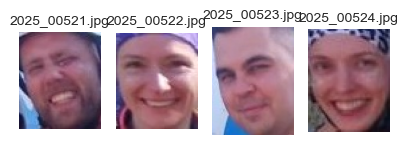

In [9]:
# пути
grp_p = f"data/raw/2025/westra_tk_2025_0629.jpg"
face_dir = f"data/faces_raw/2025"
faces = [os.path.join(face_dir, f"2025_{i:05d}.jpg") for i in (521, 522, 523, 524)]

# групповой снимок
grp = cv2.imread(grp_p)
grp = cv2.cvtColor(grp, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(grp); plt.axis("off"); plt.title("westra_tk_2025_0629.jpg")
plt.show()

# вырезанные лица
plt.figure(figsize=(4, 4))
for i, p in enumerate(faces):
    f = cv2.imread(p)
    f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(1, 4, i + 1)
    ax.imshow(f); ax.axis("off"); ax.set_title(os.path.basename(p), fontsize=10)
plt.tight_layout(); plt.show()

### Уникальные лица (+фильтр)

### Первичный анализ по лицам

In [10]:
#Основные данные об электродах;
df_face = pd.read_csv(OUTPUT_CSV, sep=',', decimal='.')

df_face.sample(5)

,filename,face_number,gender,gender_score,emotion,emotion_score,age,analysis_time,folder,emotion_rank
798,2025_face_00056.jpg,57,Man,97.79,NaN,97.31,29,2025-05-03 12:29:17,2025,0
899,2025_face_00157.jpg,158,Man,100.00,neutral,99.15,41,2025-05-03 12:30:07,2025,4
430,2024_face_00088.jpg,89,Man,97.68,NaN,67.09,38,2025-05-03 12:25:41,2024,0
342,2024_face_00000.jpg,1,Man,96.92,angry,84.82,35,2025-05-03 12:24:56,2024,2
107,2022_face_00107.jpg,108,Woman,99.06,happy,94.12,36,2025-05-03 12:21:10,2022,5


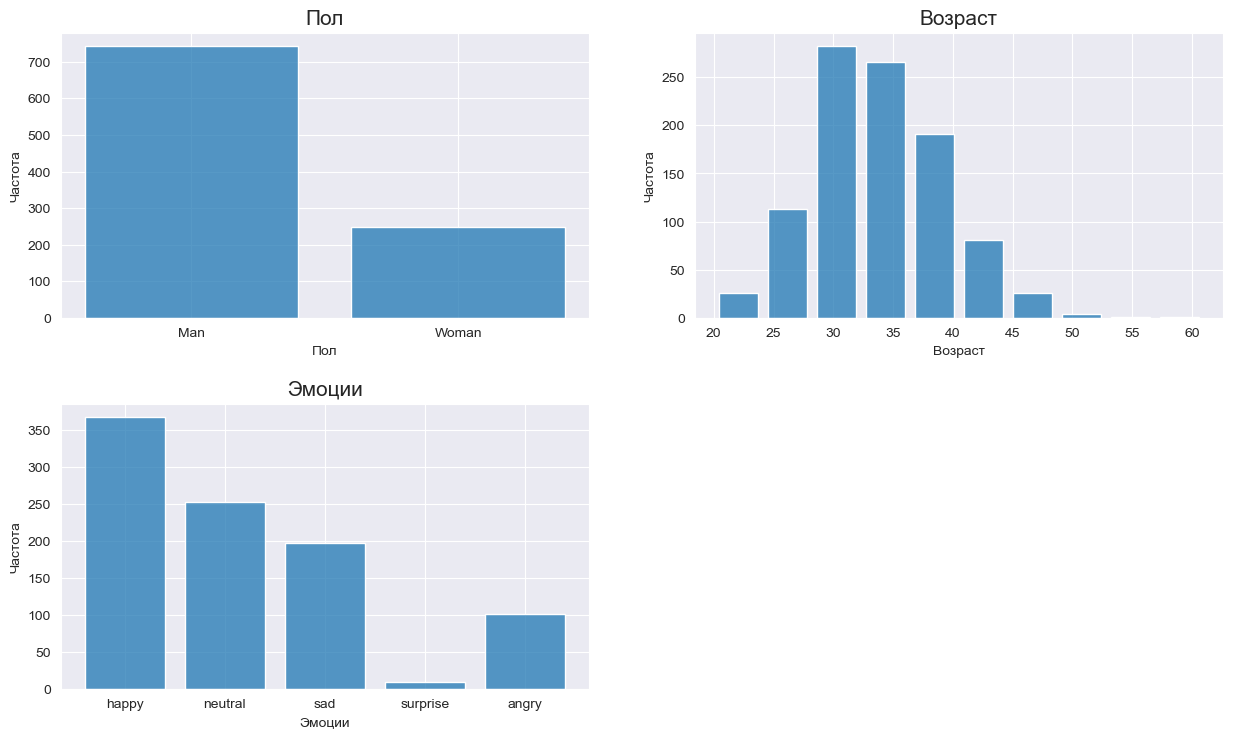

In [11]:
#Параметры для построения графиков
list_param = ['gender', 'age','emotion']
#Наименования параметров для построения графиков
list_name_param = ['Пол', 'Возраст', 'Эмоции']
#Заголовок листа
suptitle = ''
#Построение графиков
hist_graph (df_face,list_param,list_name_param , suptitle)

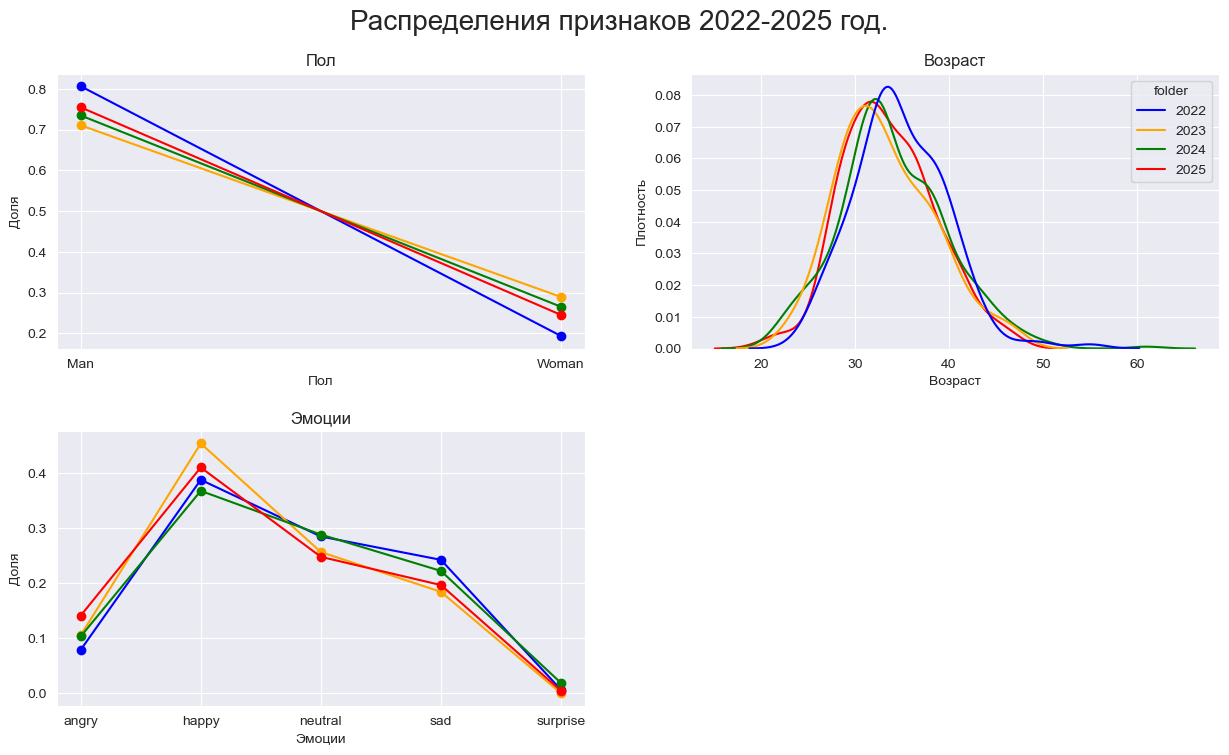

In [12]:
# Параметры
list_param      = ['gender', 'age', 'emotion']
list_name_param = ['Пол', 'Возраст', 'Эмоции']
suptitle        = 'Распределения признаков 2022-2025 год.'
p_hue           = 'folder'

# Сохраняем общий CSV
df_face.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

# Строим графики
kde_graph(df_face, list_param, list_name_param, suptitle, p_hue)

**Тренды изменения аудитории по годам:** относительный kde график эмоций и влозраста, по каждому году 

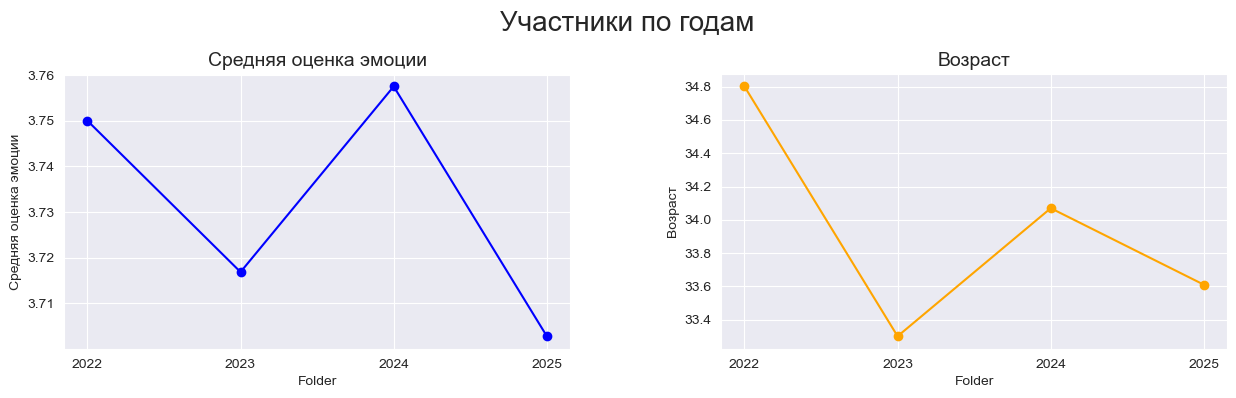

In [13]:
# словарь агрегаторов
agg_kwargs = {'emotion_rank':('emotion_rank', 'mean'),
              'age':('age', 'mean'),}

# словарь с кастомными заголовками
titles = {'emotion_rank':'Средняя оценка эмоции',
          'age':'Возраст',}

kde_graph_count (df_face, 'folder', agg_kwargs,  titles, 'Участники по годам')

## Цифровой след

### VK: посты по ключевому слову

In [14]:
#  Авторизация
vk = vk_api.VkApi(token=TOKEN)
OWNER_ID =  next(iter(GROUPS.values()))

#  Поиск через newsfeed.search
def get_posts_newsfeed(query, start_time, end_time, limit=500):
    posts = []
    next_from = ""
    total = 0

    while total < limit:
        try:
            params = {
                "q": query,
                "start_time": start_time,
                "end_time": end_time,
                "count": 100,
            }
            if next_from:
                params["start_from"] = next_from

            resp = vk.method("newsfeed.search", params)
            items = resp.get("items", [])
            posts.extend(items)
            total += len(items)

            if "next_from" in resp:
                next_from = resp["next_from"]
            else:
                break

            time.sleep(0.34)
        except ApiError as e:
            print(f" Ошибка API (newsfeed): {e}")
            break

    return posts

#  Поиск через wall.get
def get_posts_wall(owner_id, search_text=None, limit=500):
    posts = []
    offset = 0
    batch = 100

    while len(posts) < limit:
        try:
            resp = vk.method("wall.get", {
                "owner_id": OWNER_ID,
                "count": batch,
                "offset": offset
            })
        except ApiError as e:
            print(f" Ошибка API (wall): {e}")
            break

        items = resp.get("items", [])
        if not items:
            break

        for post in items:
            date = post["date"]
            if not (START_TIME <= date <= END_TIME):
                continue
            if search_text and search_text.lower() not in post.get("text", "").lower():
                continue
            posts.append(post)

        offset += batch

    return posts

#  Преобразование в DataFrame
def to_dataframe(posts):
    return pd.DataFrame([{
        'post_id': p['id'],
        'owner_id': p['owner_id'],
        'date': dt.datetime.fromtimestamp(p['date']),
        'year': dt.datetime.fromtimestamp(p['date']).year,
        'month': dt.datetime.fromtimestamp(p['date']).month,
        'text': p.get('text', ''),
        'views': p.get('views', {}).get("count", 0),
        'likes': p.get('likes', {}).get("count", 0),
        'comments': p.get('comments', {}).get("count", 0),
        'reposts': p.get('reposts', {}).get("count", 0),
        'post_url': f"https://vk.com/wall{p['owner_id']}_{p['id']}"
    } for p in posts])



In [15]:
#  Запуск обоих методов
posts_wall = get_posts_wall(OWNER_ID, search_text=SEARCH_TEXT, limit=POSTS_LIMIT)
df_wall = to_dataframe(posts_wall)
df_wall['level'] = 'root_post'
posts_news = get_posts_newsfeed(SEARCH_TEXT, START_TIME, END_TIME, POSTS_LIMIT)
df_news = to_dataframe(posts_news)
df_news['level'] = 'user_post'

# --- 4. Фильтрация по ключевым словам постов Уровня 2 ---
pattern = r'\b(' + '|'.join(SUB_QUERY) + r')\b'
df_news = df_news[df_news['text'].str.contains(pattern, case=False, regex=True, na=False)]
df_news = df_news[df_news['owner_id']!=OWNER_ID]

# Объединение и удаление дублей
df_posts = pd.concat([df_wall, df_news], ignore_index=True)
df_posts['reaction'] = df_posts['likes'] + df_posts['reposts'] + df_posts['comments']

#  Вывод
print(f" wall.get: найдено {len(df_wall)}")
print(f" newsfeed.search (фильтровано по owner_id): найдено {len(df_news)}")
print(f" Объединено без дублей: {len(df_posts)}")
df_posts.head()

 wall.get: найдено 26
 newsfeed.search (фильтровано по owner_id): найдено 79
 Объединено без дублей: 105


,post_id,owner_id,date,year,month,text,views,likes,comments,reposts,post_url,level,reaction
0,5923,-403500,2025-04-28 19:00:01,2025,4,"🎉 ТГТ завершились, и мы наконец узнали результаты! 🎉 \n\nБудет много текста, потому что много победителей и призеров...",1837,80,1,10,https://vk.com/wall-403500_5923,root_post,91
1,5913,-403500,2025-04-24 18:00:02,2025,4,"Пока мы ждём итогов, давайте вспомним, как прошли соревнования ТГТ Вестры 2025!\n \n☀️Два насыщенных дня, солнечная ...",2160,76,1,1,https://vk.com/wall-403500_5913,root_post,78
2,5911,-403500,2025-04-22 11:15:28,2025,4,"Соревнования по ТГТ и ориентированию подошли к концу! 🎯🏆 \nА пока подсчитываются результаты, нам важно узнать ваше м...",1725,63,0,1,https://vk.com/wall-403500_5911,root_post,64
3,5904,-403500,2025-04-14 11:30:00,2025,4,🚀 До старта ТГТ Вестры 2025 остались считанные дни! \n \n🧭 Выкладываем условия проведения соревнований на дистанциях...,1819,43,3,2,https://vk.com/wall-403500_5904,root_post,48
4,5899,-403500,2025-04-02 18:15:00,2025,4,"🏔 ""ТГТ Вестра 2025"" – пора проверить свои силы на соревнованиях по технике горного туризма!\n\n📅 Даты: 19–20 апреля ...",2247,54,0,11,https://vk.com/wall-403500_5899,root_post,65


In [16]:
#  Загрузка комментариев к каждому посту
def get_comments(owner_id, post_id, max_comments=20):
    try:
        response = vk.method('wall.getComments', {
            'owner_id': owner_id,
            'post_id': post_id,
            'count': max_comments,
            'preview_length': 0,
            'extended': 0
        })
        return response.get('items', [])
    except Exception as e:
        print(f" Ошибка получения комментариев для post_id={post_id}: {e}")
        return []

#  Сбор комментариев в датафрейм
comment_data = []

for _, row in df_posts.iterrows():
    comments = get_comments(row['owner_id'], row['post_id'])
    for c in comments:
        comment_data.append({
            'post_id': row['post_id'],
            'owner_id': row['owner_id'],
            'date': dt.datetime.fromtimestamp(c['date']),
            'year': dt.datetime.fromtimestamp(c['date']).year,
            'month': dt.datetime.fromtimestamp(c['date']).month,
            'text': c.get('text', ''),
            'views': None,
            'likes': c.get('likes', {}).get("count", 0),
            'comments': None,
            'reposts': None,
            'post_url': row['post_url'],
            'level': 'comment'  # Комментарии
        })

df_comments = pd.DataFrame(comment_data)
df_comments['reaction'] = df_comments['likes']  # пока только лайки

#  Объединяем
df_posts_full = pd.concat([df_posts, df_comments], ignore_index=True)

# Сохраняем общий CSV
df_posts_full.to_csv(OUTPUT_CSV_POST, index=False, encoding="utf-8")
print(f"\n Финальный CSV сохранён в {OUTPUT_CSV_POST}")

 Ошибка получения комментариев для post_id=3527: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=2166: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=326: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=8572: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=325: [212] Access to post comments denied
 Ошибка получения комментариев для post_id=2729: [212] Access to post comments denied

 Финальный CSV сохранён в dataset/analysis_post.csv


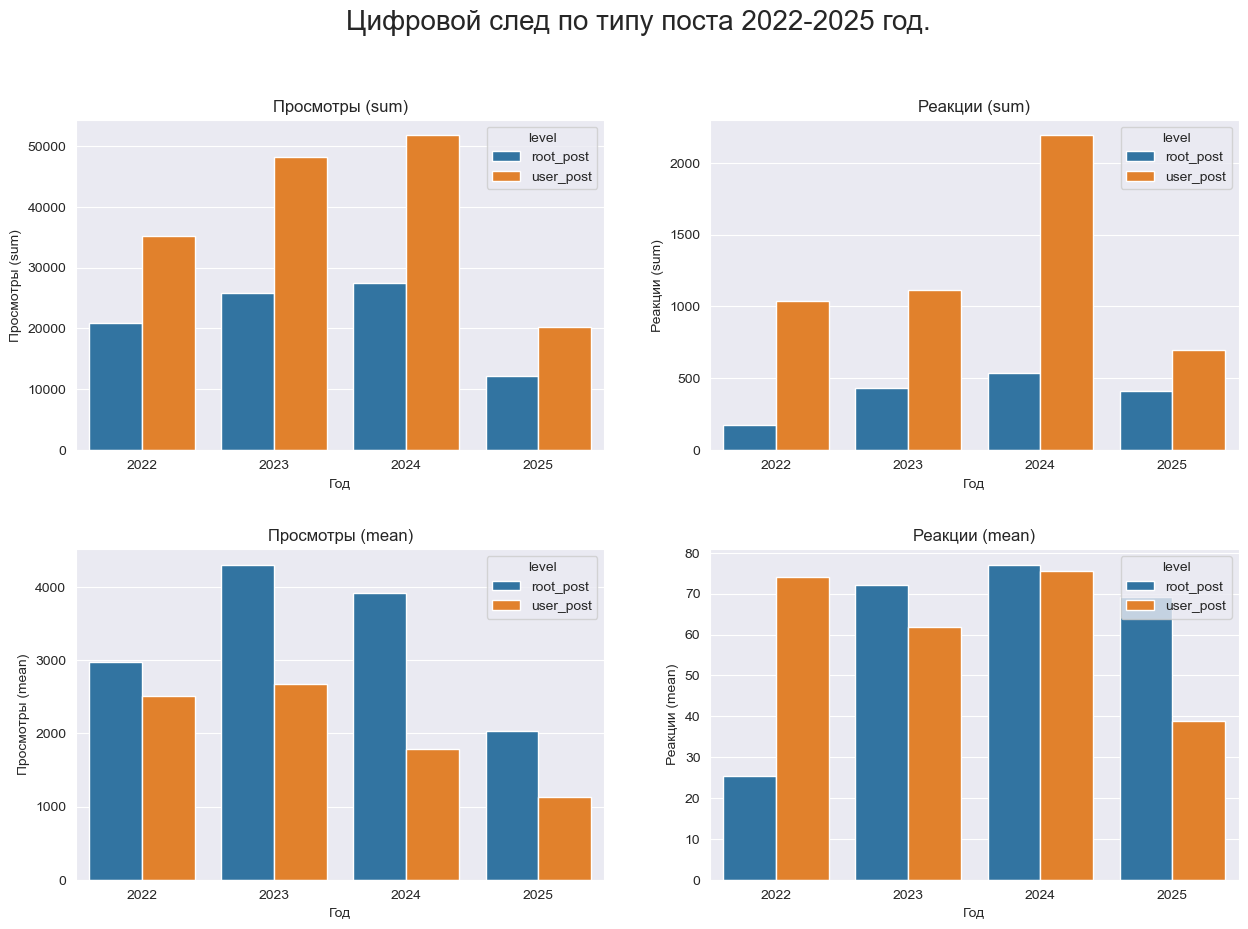

In [17]:
# Параметры
list_param      = ['views_s', 'reaction_s', 'views_m', 'reaction_m']
list_name_param = ['Просмотры (sum)', 'Реакции (sum)', 'Просмотры (mean)', 'Реакции (mean)']
suptitle        = 'Цифровой след по типу поста 2022-2025 год.'
x_n = 'year'
p_hue  = 'level'

df_pivot = df_posts_full[df_posts_full['level'].isin(['root_post', 'user_post'])].pivot_table(
    index=['year', 'level'],
    values=['views', 'reaction'],
    aggfunc={'views': ['mean', 'sum'], 'reaction': ['mean', 'sum']}
).reset_index()

df_pivot.columns = ['year', 'level', 'reaction_m' , 'reaction_s' , 'views_m' , 'views_s' ]
df_pivot.head()


#df_pivot = df_posts.pivot_table(index= [x_n, p_hue], values=list_param, aggfunc='sum').reset_index()

bar_graph (df_pivot, x_n, list_param,list_name_param, suptitle, p_hue  = 'level')

### Inst: анализ по тегу

In [18]:
##### ===========================================================================
##### !!!! Возможность получать статистику с Instagram через библиотеку      !!!!
##### !!!! instaloader на территории РФ заблокирована на уровне провайдеров. !!!!
##### ===========================================================================

# import instaloader
# L = instaloader.Instaloader()

# USERNAME = "login"     # Введи имя пользователя Instagram
# PASSWORD = "passw"     # Введи пароль

# # Авторизация
# L.login(USERNAME, PASSWORD)

# # Сохраняем сессию, чтобы не логиниться заново в будущем
# L.save_session_to_file()

# hashtag = "тгт"
# posts = instaloader.Hashtag.from_name(L.context, hashtag).get_posts()

# data = []
# for post in posts:
#     data.append({
#         'date': post.date_utc,
#         'text': post.caption,
#         'likes': post.likes,
#         'comments': post.comments,
#         'shortcode': post.shortcode,
#         'url': f"https://www.instagram.com/p/{post.shortcode}/"
#     })
#     if len(data) > 100:  # ограничение на количество постов
#         break

# import pandas as pd
# df_ig = pd.DataFrame(data)
# df_ig.head()

### Эмоциональный фон постов и комментариев

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Загружаем данные
df_sent = pd.read_csv(OUTPUT_CSV_POST)

# 1. Модель и токенизатор
model_name = 'blanchefort/rubert-base-cased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. Токенизация (сразу батч)
texts = df_sent['text'].fillna('').tolist()
tokens = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

# 3. Предсказания
with torch.no_grad():
    outputs = model(**tokens)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).numpy()

# 4. Сохраняем в DataFrame
df_sent['sentiment_label'] = np.argmax(probs, axis=1)
df_sent['sentiment_score'] = np.max(probs, axis=1)
df_sent['sentiment'] = df_sent['sentiment_label'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

In [20]:
# 1. Определим границы интервалов внутри каждой категории
sentiment_bounds = {}

for label in ['negative', 'neutral', 'positive']:
    subset = df_sent[df_sent['sentiment'] == label]['sentiment_score']
    if not subset.empty:
        min_score = subset.min()
        max_score = subset.max()
        bins = np.linspace(min_score, max_score, 4)  # 3 интервала = 4 границы
        sentiment_bounds[label] = bins

# 2. Присваиваем значения от 1 до 9 по интервалам
def map_sentiment_score(row):
    bins = sentiment_bounds.get(row['sentiment'])
    if bins is None:
        return np.nan

    idx = np.digitize(row['sentiment_score'], bins, right=False) - 1
    idx = max(0, min(2, idx))  # гарантируем, что будет от 0 до 2

    if row['sentiment'] == 'negative':
        return 1 + idx
    elif row['sentiment'] == 'neutral':
        return 4 + idx
    elif row['sentiment'] == 'positive':
        return 7 + idx

df_sent['sentiment_9scale'] = df_sent.apply(map_sentiment_score, axis=1)

# Сохраняем общий CSV
df_sent.to_csv(OUTPUT_CSV_POST, index=False, encoding="utf-8")
print(f"\n Финальный CSV сохранён в {OUTPUT_CSV_POST}")


 Финальный CSV сохранён в dataset/analysis_post.csv


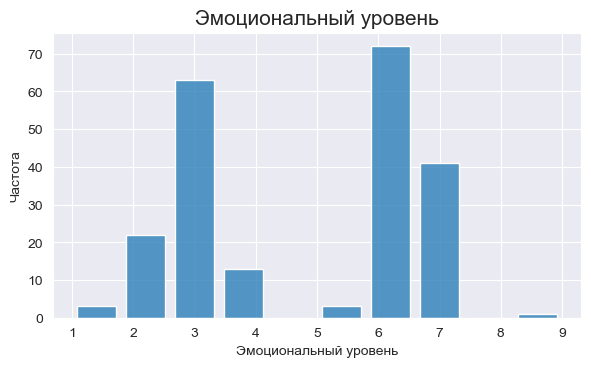

In [21]:
#Параметры для построения графиков
list_param = ['sentiment_9scale']
#Наименования параметров для построения графиков
list_name_param = ['Эмоциональный уровень']
#Заголовок листа
suptitle = ''
#Построение графиков
hist_graph (df_sent,list_param,list_name_param , suptitle)

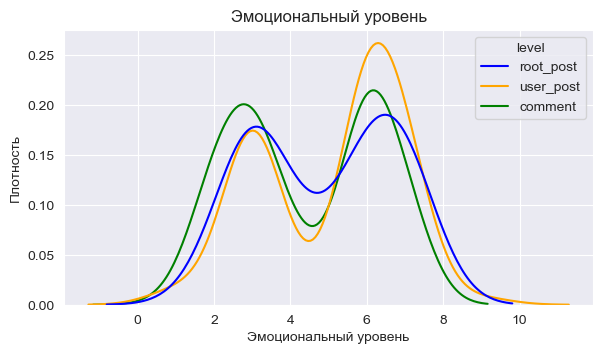

In [22]:
#Параметры для построения графиков
list_param = ['sentiment_9scale']
#Наименования параметров для построения графиков
list_name_param = ['Эмоциональный уровень']
#Заголовок листа
suptitle = ''
#Построение графиков
kde_graph (df_sent,list_param,list_name_param , suptitle, 'level')

Важно подчеркнуть, что посты-объявления написанные официальным тоном. Модель воспринимает ближе к негативным, по эмоциональному содержанию (ближе к 3).

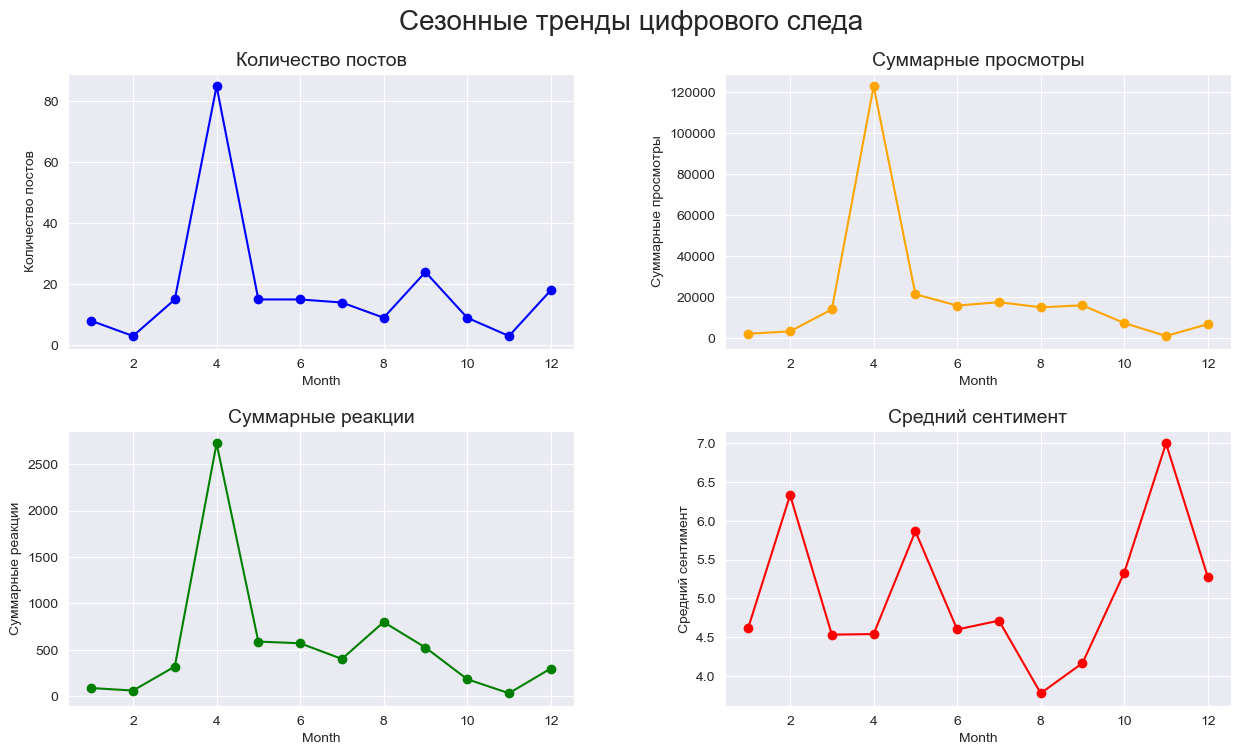

In [23]:
# словарь агрегаторов
agg_kwargs = {
    'post_count'    : ('year',            'size'),
    'views_sum'     : ('views',           'sum'),
    'reaction_sum'  : ('reaction',        'sum'),
    'sentiment_mean': ('sentiment_9scale','mean'),
}

# словарь с кастомными заголовками
titles = {
    'post_count'    : 'Количество постов',
    'views_sum'     : 'Суммарные просмотры',
    'reaction_sum'  : 'Суммарные реакции',
    'sentiment_mean': 'Средний сентимент'
}

kde_graph_count (df_sent, 'month', agg_kwargs,  titles, 'Сезонные тренды цифрового следа')

Годовые тренды

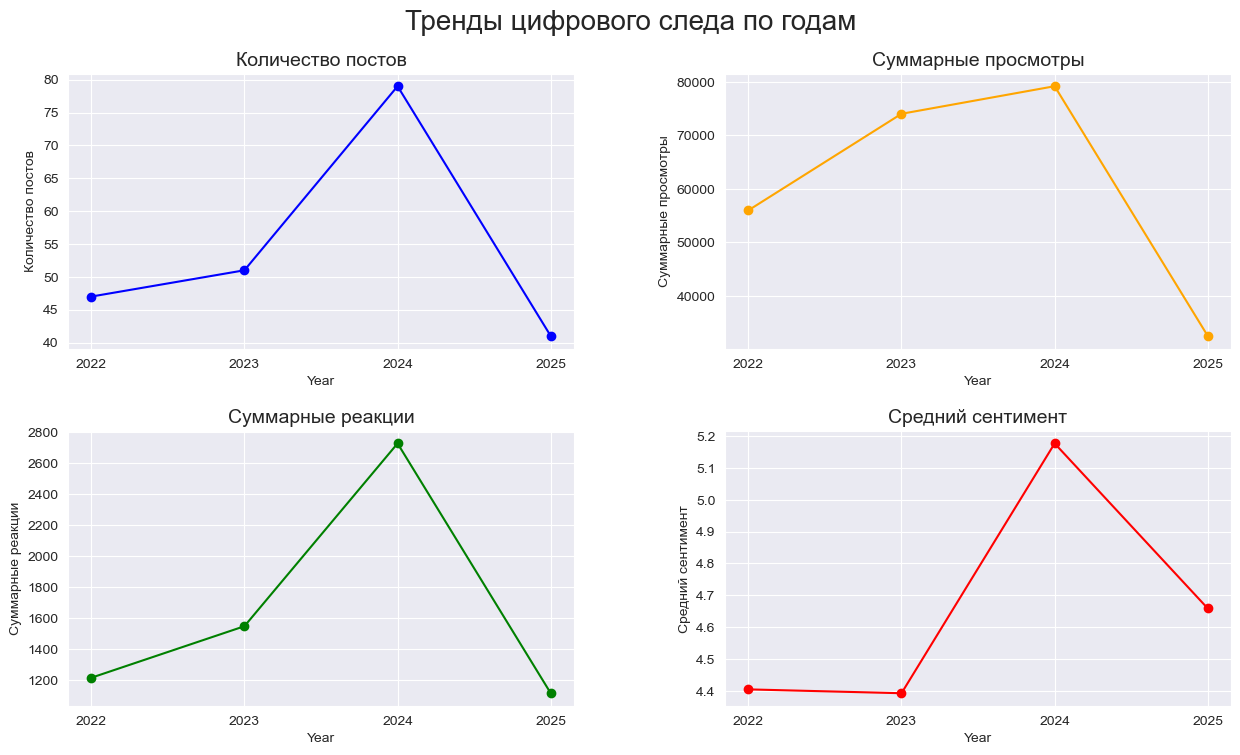

In [24]:
# словарь агрегаторов
agg_kwargs = {
    'post_count'    : ('year',            'size'),
    'views_sum'     : ('views',           'sum'),
    'reaction_sum'  : ('reaction',        'sum'),
    'sentiment_mean': ('sentiment_9scale','mean'),
}

# словарь с кастомными заголовками
titles = {
    'post_count'    : 'Количество постов',
    'views_sum'     : 'Суммарные просмотры',
    'reaction_sum'  : 'Суммарные реакции',
    'sentiment_mean': 'Средний сентимент'
}
kde_graph_count (df_sent, 'year', agg_kwargs,  titles, 'Тренды цифрового следа по годам')

### Преобладающая тематика

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Doctor_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Тема 1: вестра, школы, также, club, школа, сделать, соревнования, горная
Тема 2: день, время, место, соревнования, поход, туризма, просто, туризму
Тема 3: новое, место, очень, города, club, люди, которые, именно
Тема 4: года, году, дистанция, работы, жизни, связки, результаты, зачет
Тема 5: место, апреля, соревнования, вестра, также, среди, участие, соревнований


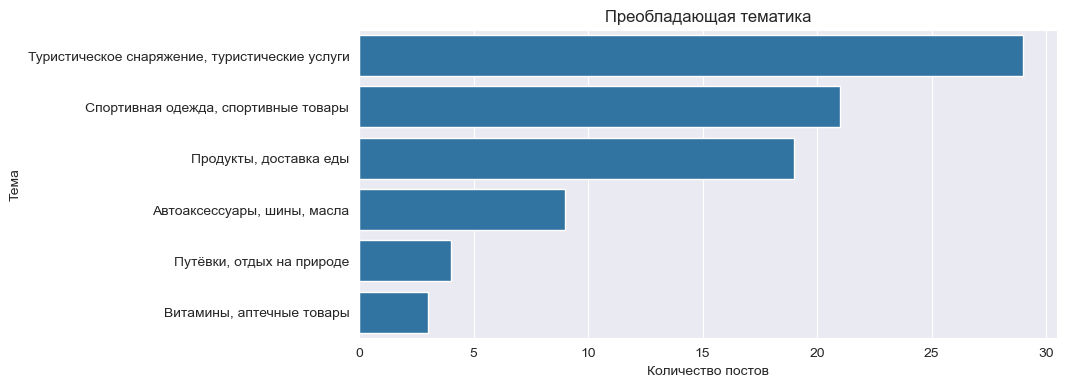

In [25]:
# 1. Загрузка данных 
df_post = pd.read_csv(OUTPUT_CSV_POST, encoding='utf-8')

# 2. Подготовка стоп-слов 
nltk.download('stopwords')
stop_words = set(stopwords.words('russian')) | set(stopwords.words('english'))

# 3. Инициализация токенизатора 
tokenizer = RegexpTokenizer(r'[а-яеa-z]+')  # включаем 'е' вместо 'ё'

# 4. Очистка и токенизация для LDA 
texts_clean = []
for raw in df_post['text'].dropna().astype(str):
    text = raw.lower().replace('ё', 'е')
    text = re.sub(r"http\S+|www\S+|[^а-яеa-z\s]", " ", text)
    tokens = tokenizer.tokenize(text)
    tokens = [tok for tok in tokens if tok not in stop_words and len(tok) > 3 and not tok.isdigit()]
    if tokens:
        texts_clean.append(tokens)

# 5. Создание словаря и корпуса
id2word = corpora.Dictionary(texts_clean)
id2word.filter_extremes(no_below=5, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in texts_clean]

# 6. Обучение LDA-модели
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=42,
    passes=10
)

#  7. Сохранение тем LDA 
with open(OUTPUT_LDA_TOPICS, 'w', encoding='utf-8') as f:
    for topic_id in range(lda_model.num_topics):
        terms = lda_model.show_topic(topic_id, topn=8)
        words = [word for word, _ in terms]
        line = f"Тема {topic_id+1}: {', '.join(words)}"
        print(line)
        f.write(line + '\n')

def detect_theme(text):
    text = text.lower()
    return [kw for kw in theme_to_category if kw in text]

#  9. Классификация постов и сохранение результатов 
posts_data = []
# Используем индекс DataFrame как post_id, т.к. колонки 'id' нет
for idx, raw in df_post['text'].dropna().items():
    text = str(raw).lower()
    themes = detect_theme(text)
    for theme in themes:
        posts_data.append({
            'post_id': idx,
            'theme_detected': theme,
            'category_recommendation': theme_to_category[theme],
            'post_text_snippet': text[:100]
        })

# Создаём папку, если нужно
df_recommendations = pd.DataFrame(posts_data)
df_pivot_rec = df_recommendations.pivot_table(index=['category_recommendation', 'theme_detected',], values = 'post_id', aggfunc = 'count').sort_values ('post_id', ascending = False)

#Функция для построения графиков распределения в каждом из признаков .
#График распределения всех параметров по категориям
plt.figure(figsize=[9, 4])
sns.barplot(data=df_pivot_rec, x='post_id', y='category_recommendation')
plt.xlabel('Количество постов', fontsize="10")
plt.ylabel('Тема', fontsize="10")
plt.title('Преобладающая тематика', fontsize="12")
plt.show()

In [26]:
# перекладываем в тему только те столбцы, которые нужны, и ставим post_id в индекс
theme_idx = df_recommendations.set_index('post_id')[['theme_detected','category_recommendation']]

# «лёгкий» join по индексу df_post и индексу theme_idx
df_post_full = df_post.join(theme_idx, how='left')

df_post_full.to_csv(OUTPUT_CSV_POST, index=False, encoding='utf-8-sig')
print(f" Сохранено в файл {OUTPUT_CSV_POST}")


 Сохранено в файл dataset/analysis_post.csv


**Тематические тренды по годам:** Как изменяется интерес к тематикам. 

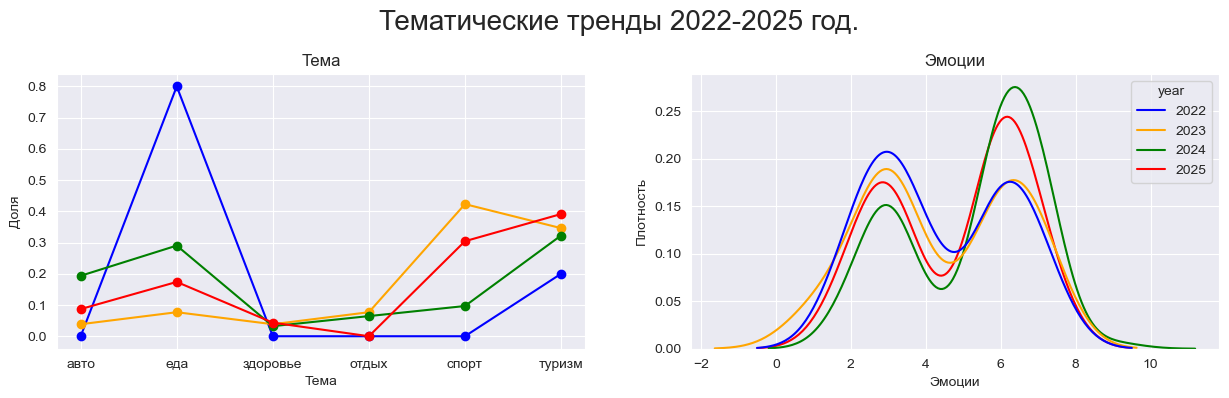

In [27]:
# Параметры
list_param      = ['theme_detected', 'sentiment_9scale']
list_name_param = ['Тема', 'Эмоции']
suptitle        = 'Тематические тренды 2022-2025 год.'
p_hue           = 'year'

# Строим графики
kde_graph(df_post_full, list_param, list_name_param, suptitle, p_hue)

## Итоговый вывод

### Общие вводные

В рамках проекта был проанализирован цифровой след соревнований по технике горного туризма (ТГТ), которые проводятся ежегодно в апреле с 2022 по 2025 год. Эти мероприятия собирают от 150 до 200 участников, представляя собой стабильное и хорошо организованное событие с узнаваемой повесткой.


### Фотографии и фотоанализ

Для анализа использовались публичные альбомы во «ВКонтакте» — от 550 до 1300 фотографий в каждом. После удаления дублирующих и нерелевантных изображений, объём выборки оказался в 5 раз больше, чем число участников, что позволило провести достоверный демографический и эмоциональный анализ.

Обработка \~3000 фотографий с помощью CPU i7-8700 заняла около 8 часов. Лица и эмбединги сохранялись отдельно, чтобы избежать повторных вычислений. Были реализованы фильтры для удаления мусорных снимков — визуальный контроль показал уровень ошибки не выше 5%.

Результаты:

* Гендерный состав: 71% мужчин и 29% женщин.
* Средний возраст: 33–34 года, ядро целевой аудитории — 25–44 года.
* Эмоциональный фон: преимущественно нейтрально-позитивный.
* Отрицательные эмоции (грусть, злость) наблюдаются не как реакция на событие, а как отражение напряжённых моментов соревнований.

Интересно, что с года в год эмоциональный фон остаётся стабильным, что подтверждает гипотезу о «консервативности» формата ТГТ: испытания и организационные паттерны повторяются, аудитория — постоянна.

### Посты, комментарии и цифровая активность

Для анализа использовались:

* посты в группах мероприятия;
* публичные посты участников;
* комментарии (в тех случаях, где был доступ);
* частично — сторис Telegram и попытка анализа Instagram (неудалась из-за ограничений в РФ).

Суммарная цифровая активность по годам:

* Просмотры: от 50 до 80 тысяч в год.
* Реакции: от 1.2 до 2.5 тысяч (конверсия 1.5–2%).
* Интересно, что посты от самих участников получают в 2 раза больше просмотров, чем публикации от лица группы.

 С 2022 по 2024 год наблюдался устойчивый рост активности. Однако в 2025 году зафиксирован спад. Если предположить наличие 5-летнего волнового цикла интереса к подобным мероприятиям, можно ожидать новый виток роста уже через 1–2 года.


### Тональность постов и комментариев

С помощью модели BERT (`blanchefort/rubert-base-cased-sentiment`) был проведён анализ тональности:

* Преобладают сдержанно-нейтральные и позитивные посты.
* Корневые публикации от групп — в официальном стиле (тональность \~3).
* Посты участников и комментарии чаще содержат позитив (\~6–7).
* Комментарии также часто несут эмоциональную окраску — благодарности, радость, переживания.

На шкале от 1 до 9 (расширенная градация на основе вероятности) большую часть занимают уровни 4–7, что соответствует умеренно-позитивной коммуникации.


### Тематики

Анализ тем с помощью BERTopic и SentenceTransformer выявил ключевые области интересов:

* Снаряжение и оборудование
* Туризм и спорт
* Еда и питание в походах

Эти тематики логично соотносятся с повесткой мероприятия и ожиданиями аудитории.

### Сезонность

Апрель — месяц пиковых значений как по числу постов, так и по реакции. Дополнительно выявлены два мини-пика:

* Ноябрь — время набора в школы туризма (рост позитивной коммуникации).
* Май-июнь — публикации фотоотчётов и «впечатлений после».

### Вывод по вовлечённости

Если проанализировать численность группы ВКонтакте и число активных взаимодействий (просмотры, лайки, комментарии, участие в соревнованиях), можно сделать вывод:

 **Активное ядро** сообщества — около 1000 человек (\~20% от численности группы).

Это те, кто участвуют в соревнованиях, походах, слётах, активно читают и комментируют контент. Именно с ними стоит работать точечно, выстраивая коммуникации и продвижение.

##  Рекомендации по развитию исследования

Чтобы сделать анализ ещё более точным и связать цифровой след с физическим участием:

1. **Геометки на фотографиях**
   Сбор координат позволит определить, какие эмоции чаще связаны с определёнными этапами соревнований или локациями. Например, больше радости — на финише, больше напряжения — у «параллельных перил».

2. **Офлайн-анкетирование**
   На старте или в конце соревнований можно предлагать заполнить короткую анкету: имя, ссылка на профиль ВК, возраст, род занятий. Это позволит привязать фотографии и посты к конкретным людям и сегментировать аудиторию точнее.

3. **Telegram**
   Развивать канал мероприятия с сохранением сторис, созданием чатов команд, сбором упоминаний по хештегу — это увеличит видимость и позволит обогатить данные анализа.

4. **Подключение аудио/видеоанализа**
   В будущем — анализ эмоций не только по фото, но и по голосу, фразам и выражениям лиц в видео.

## Вывод

События ТГТ — это стабильный, локально сильный формат. Он держит вовлечённую аудиторию, но требует периодического перезапуска интереса. Мы находимся у нижней точки цикла. Если следовать пятигодичному тренду, уже в ближайшие 1–2 года можно ожидать новый подъём.

В условиях роста интереса к активному отдыху, туризму и походному снаряжению, есть смысл начинать продвигать партнёрские бренды уже сейчас. Наиболее эффективные окна:

* **Ноябрь** — наборы в Школы горного туризма;
* **Апрель** — пик интереса во время мероприятия; всплеск эмоций и фотоконтента после.

Уровень позитивной вовлечённости и плотность сообщества позволяют использовать этот канал как основу для долгосрочной маркетинговой работы.
